/vera/u/jshera/CL/new_venv/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.6.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


num samples out of bounds: 0
number of parameters: 727736
GraphINN(
  (module_list): ModuleList(
    (0-7): 8 x RationalQuadraticSplineBlock(
      (softplus): Softplus(beta=0.5, threshold=20.0)
      (subnet): Subnet(
        (layers): Sequential(
          (0): Linear(in_features=10, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=256, bias=True)
          (3): ReLU()
          (4): Linear(in_features=256, out_features=87, bias=True)
        )
      )
    )
  )
)


/tmp/ipykernel_44156/3626666178.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_checkpoint, map_location=device)


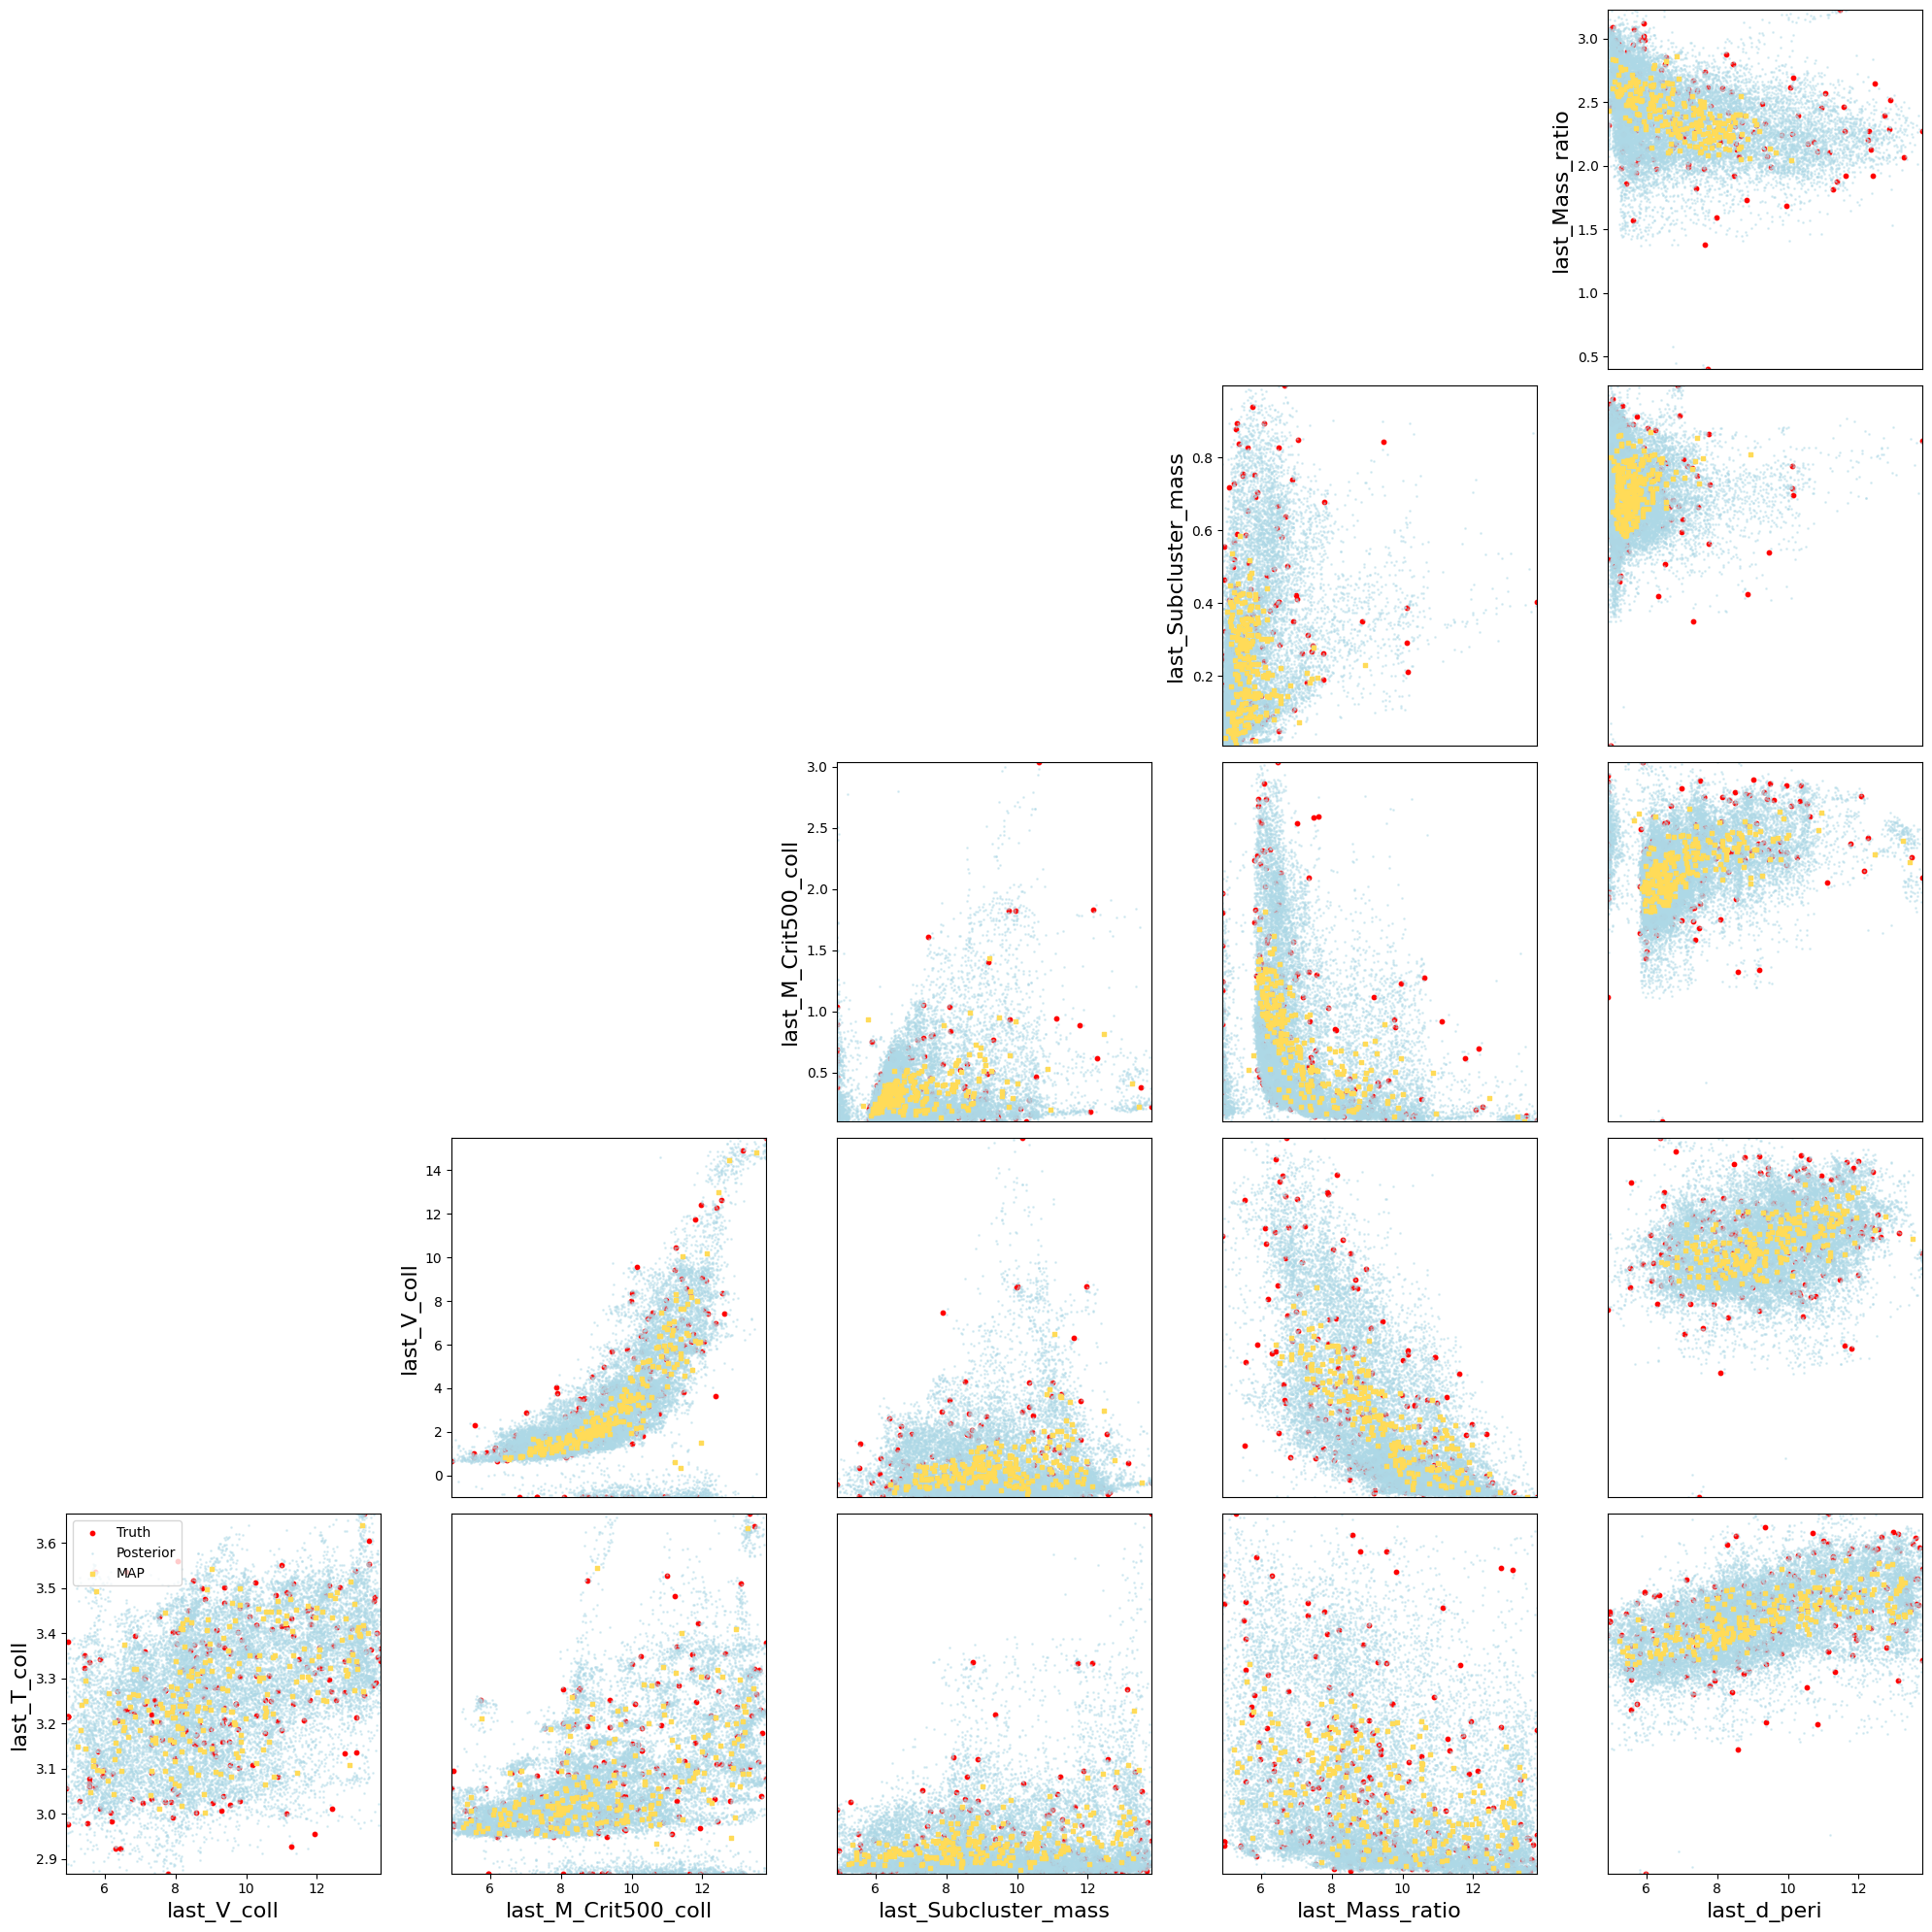

In [1]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import yaml
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from model import CINN
from plot_utils import sample_posteriors

TARGET_COLS = [
    'last_T_coll',
    'last_V_coll',
    'last_M_Crit500_coll',
    'last_Subcluster_mass',
    'last_Mass_ratio',
    'last_d_peri'
]

def plot_pairwise_all_three(model_checkpoint: str,
                            processed_dir: str = "processed_data",
                            params_path: str = "params.yaml",
                            n_posterior_samples: int = 600,
                            max_post_samples: int = 20000,
                            random_state: int = 42):
    # Load data
    X = pd.read_csv(os.path.join(processed_dir, "X.csv")).values
    Y = pd.read_csv(os.path.join(processed_dir, "Y.csv")).values
    tar_sc = joblib.load(os.path.join(processed_dir, "tar_scaler.pkl"))

    idx = np.arange(len(X))
    _, idx_test = train_test_split(idx, test_size=0.1, random_state=random_state)
    X_test = X[idx_test]
    Y_test = Y[idx_test]
    truth = tar_sc.inverse_transform(Y_test)

    # Load model
    with open(params_path, "r") as f:
        params = yaml.safe_load(f)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = CINN(params=params,
                 data=torch.tensor(Y, dtype=torch.float32),
                 cond=torch.tensor(X, dtype=torch.float32)).to(device)

    checkpoint = torch.load(model_checkpoint, map_location=device)
    model.load_state_dict(checkpoint["net"] if "net" in checkpoint else checkpoint)
    model.eval()

    # Sample posteriors
    post_samples = sample_posteriors(model, X_test, tar_sc, n_samples=n_posterior_samples, device=device)
    maps = post_samples.mean(axis=1)
    post_flat = post_samples.reshape(-1, post_samples.shape[-1])

    # Plot
    D_tar = Y.shape[1]
    size = D_tar - 1
    fig, axes = plt.subplots(size, size, figsize=(4 * size, 4 * size), squeeze=False)
    rng = np.random.RandomState(random_state)

    for i in range(size):
        for j in range(i + 1, D_tar):
            ax = axes[size - 1 - i, j - 1]
            gt_pts = truth[:, [i, j]]
            post_pts = post_flat[:, [i, j]]
            map_pts = maps[:, [i, j]]

            total = post_pts.shape[0]
            post_sub = post_pts[rng.choice(total, max_post_samples, replace=False)] if total > max_post_samples else post_pts

            ax.scatter(gt_pts[:, 0], gt_pts[:, 1], c='red', s=10, alpha=1.0)
            ax.scatter(post_sub[:, 0], post_sub[:, 1], c='lightblue', s=1, alpha=0.4)
            ax.scatter(map_pts[:, 0], map_pts[:, 1], c='#FFDB58', s=10, marker='s', alpha=1.0)

            ax.set_xlim(gt_pts[:, 0].min(), gt_pts[:, 0].max())
            ax.set_ylim(gt_pts[:, 1].min(), gt_pts[:, 1].max())

            if j == i + 1:
                ax.set_ylabel(TARGET_COLS[i], fontsize=16)
            else:
                ax.set_yticks([])
            if i == 0:
                ax.set_xlabel(TARGET_COLS[j], fontsize=16)
            else:
                ax.set_xticks([])

            if i == 0 and j == 1:
                ax.legend(['Truth', 'Posterior', 'MAP'], loc='upper left')

    for r in range(size):
        for c in range(size):
            orig_i = size - 1 - r
            orig_j = c + 1
            if orig_j <= orig_i:
                axes[r, c].axis('off')

    plt.tight_layout()
    plt.savefig("4.cross_correlations.png", dpi=300, bbox_inches='tight')
    #plt.savefig("4.cross_correlations.pdf", dpi=300, bbox_inches='tight')
    plt.show()


if __name__ == "__main__":
    plot_pairwise_all_three(
        model_checkpoint="runs/20250530_211943_no_scaling/model_last.pt",
        processed_dir="processed_data",
        params_path="params.yaml",
        n_posterior_samples=100,
        max_post_samples=20000,
        random_state=42
    )
